In [79]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from meshplot import plot
import matplotlib.pyplot as plt
import sys 
sys.path.append('../')
import radfoam
import mesh_tools as mt
from radfoam_model.mesh_utils import marching_tetrahedra
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import igl
device='cuda'

In [80]:
v, f, samples = mt.load_and_sample_shape('pig.obj', '../data/',)
queries = torch.tensor(samples, device='cuda', dtype=torch.float32) 
target_mesh = Meshes(torch.tensor(v, dtype=torch.float32, device=device)[None, :],torch.tensor(f, device=device)[None, :])
plot(v,f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0656904…

In [81]:
num_init_points = 30000

primal_points = (torch.rand(num_init_points, 3, device=device)-.5)*2.

triangulation = radfoam.Triangulation(primal_points)
perm = triangulation.permutation().long()
primal_points = primal_points[perm]


sdf, _, _ = igl.signed_distance(primal_points.cpu().detach().numpy(), v, f)
primal_values = torch.tensor(sdf, dtype=torch.float32, device=device)
nv, nf, _, edge = marching_tetrahedra(triangulation.tets().long(),primal_values,primal_points, primal_points, True)
primal_points = primal_points[edge.unique()]
primal_values = primal_values[edge.unique()]

triangulation = radfoam.Triangulation(primal_points)
perm = triangulation.permutation().long()
primal_points = primal_points[perm]
primal_values = primal_values[perm]


In [82]:
nv, nf, _, edge = marching_tetrahedra(triangulation.tets().long(),primal_values,primal_points, primal_points, True)
src_mesh = Meshes(nv[None, :], nf[None, :])
plot(nv.cpu().detach().numpy(), nf.cpu().detach().numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0629344…

In [83]:
primal_values.requires_grad_(True)
primal_points.requires_grad_(True)

deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([primal_points, primal_values], lr=0.5, momentum=0.9)


In [84]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

total_loss = 0.003670:   0%|          | 0/100 [00:00<?, ?it/s]

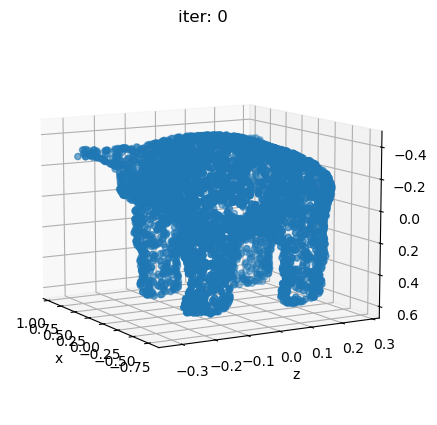

total_loss = 0.003670:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [90]:
# Number of optimization steps
Niter = 100
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    nv, nf, _, edge = marching_tetrahedra(triangulation.tets().long(),primal_values,primal_points, primal_points, True)
    new_src_mesh = Meshes(nv[None, :], nf[None, :])
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(target_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()

In [89]:
nv, nf, _, edge = marching_tetrahedra(triangulation.tets().long(),primal_values,primal_points, primal_points, True)
src_mesh = Meshes(nv[None, :], nf[None, :])
plot(nv.cpu().detach().numpy(), nf.cpu().detach().numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0677744…